# Model 2: Bayesian Neural Network

### Quantifying uncertainty to improve prediction accuracy 

This model will be built using **only** beatAML data to predict AUC, however, this time we will use a bayesian neural network. 

Following this tutorial: https://forum.pyro.ai/t/dealing-with-noise-in-bayesian-neural-network-regression/863

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle
from torch.utils import data
from matplotlib import pyplot as plt
import pandas as pd
import imageio

import torchvision
from torchvision import datasets, transforms
from matplotlib import colors
from IPython import display

import pyro
from pyro.distributions import Normal, Categorical, Uniform
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from   torch.distributions import constraints

# Utilities 

# Define our Dataset Class 

In [2]:
class DrugExpressionDataset(Dataset): 
    '''
    '''
    def __init__ (self, label_dict, root_dir='../data_pytorch/tensors'): 
        '''
        '''
        self.index = list(label_dict.keys())
        self.labels = label_dict
        self.root = root_dir
                            
    def __len__(self):
        '''
        '''
        return len(self.labels.keys())
        
    def __getitem__(self, index, response_type=False):
        '''
        '''
        fid = self.index[index]
        X = torch.load(f'{self.root}/{fid}.pt')[:10, :] #<----------------------------- number of genes to use
        _id, id_type, resp_type, response = self.labels[fid]
        
        if response_type: 
            return torch.as_tensor(X, dtype=torch.float), (response, resp_type)
        else: 
            return torch.as_tensor(X, dtype=torch.float), response

# Separate data into train/test/validate 

In [3]:
train, test, val = (0.65,0.2,0.15)

with open('../data_pytorch/label_dict.pkl', 'rb') as f: 
    label_dict = pickle.load(f)

label_dict2 = dict()
for fid in label_dict: 
    _id, id_type, resp_type, response = label_dict[fid]
    
    if resp_type not in label_dict2: 
        label_dict2[resp_type] = dict()
        
    p = np.random.rand()
    if (p < train): # add to training set 
        if 'train' in label_dict2[resp_type]: 
            label_dict2[resp_type]['train'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['train'] = {fid:(_id, id_type, resp_type, response)}

    elif (p < train+test): # add to test set 
        if 'test' in label_dict2[resp_type]: 
            label_dict2[resp_type]['test'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['test'] = {fid:(_id, id_type, resp_type, response)}
    else: # add to validation set 
        if 'val' in label_dict2[resp_type]: 
            label_dict2[resp_type]['val'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['val'] = {fid:(_id, id_type, resp_type, response)}            

In [4]:
label_dict2.keys()

dict_keys(['RNAi_dependency', 'crispr_dependency', 'pooled_drugresp_prism', 'AUC_GDSC', 'CTRP_AUC', 'AUC_drug_CCLE', 'beatAML_AUC'])

In [5]:
for resp_type in label_dict2:
    for sset in label_dict2[resp_type]: 
        pp = resp_type + ' '*(20 - len(resp_type))
        print(f'set sizes: {pp} \t-> {sset}  \t-> {len(label_dict2[resp_type][sset])}')

set sizes: RNAi_dependency      	-> train  	-> 186334
set sizes: RNAi_dependency      	-> val  	-> 43031
set sizes: RNAi_dependency      	-> test  	-> 57174
set sizes: crispr_dependency    	-> test  	-> 62372
set sizes: crispr_dependency    	-> train  	-> 202161
set sizes: crispr_dependency    	-> val  	-> 46435
set sizes: pooled_drugresp_prism 	-> test  	-> 30491
set sizes: pooled_drugresp_prism 	-> train  	-> 99099
set sizes: pooled_drugresp_prism 	-> val  	-> 22837
set sizes: AUC_GDSC             	-> train  	-> 10812
set sizes: AUC_GDSC             	-> test  	-> 3382
set sizes: AUC_GDSC             	-> val  	-> 2470
set sizes: CTRP_AUC             	-> train  	-> 17944
set sizes: CTRP_AUC             	-> val  	-> 4166
set sizes: CTRP_AUC             	-> test  	-> 5520
set sizes: AUC_drug_CCLE        	-> train  	-> 1462
set sizes: AUC_drug_CCLE        	-> test  	-> 470
set sizes: AUC_drug_CCLE        	-> val  	-> 351
set sizes: beatAML_AUC          	-> train  	-> 1136
set sizes: beatA

In [6]:
max(label_dict.keys())

798259

# Defining our model architecture 

In [105]:
class BNN_SVI:
    def __init__(self, dim, H1, H2, Hout, conf = dict()):
        self.dim           = dim
        self.print_every   = conf.get('print_every',  100)
        self.lr            = conf.get('lr',           1e-3)
        self.weight_prior  = conf.get('weight_prior', 1.0)
        self.bias_prior    = conf.get('bias_prior',   1.0)
        self.prec_alpha    = conf.get('prec_alpha', 3)
        self.prec_beta     = conf.get('prec_beta', 1)
        self.nn = nn.Sequential(
                nn.Linear(self.dim, H1), nn.Tanh(),
                nn.Linear(H1, Hout))
        self.prior_variance = 1

    def model(self, X, y):
        #noise_scale = torch.tensor(noise_level)
        precision   = pyro.sample("precision", pyro.distributions.Gamma(self.prec_alpha, self.prec_beta))
        noise_scale = 1 / precision.sqrt()
        #noise_scale = pyro.sample('noise_scale_unif', pyro.distributions.Uniform(0,10) )
        num_x       = X.shape[0]
        priors      = dict()
        for n, p in self.nn.named_parameters():
            if "weight" in n:
                priors[n] = pyro.distributions.Normal(
                        loc   = torch.zeros_like(p),
                        scale = self.prior_variance * torch.ones_like(p)).to_event(1)
            elif "bias" in n:
                priors[n] = pyro.distributions.Normal(
                        loc   = torch.zeros_like(p),
                        scale = self.prior_variance * torch.ones_like(p)).to_event(1)

        lifted_module    = pyro.random_module("module", self.nn, priors)
        lifted_reg_model = lifted_module()
        with pyro.plate("map", len(X), subsample_size = num_x) as ind:
            prediction_mean = lifted_reg_model(X[ind]).squeeze(-1)
            pyro.sample("obs", 
                    pyro.distributions.Normal(prediction_mean, noise_scale), 
                    obs = y[ind])

    def guide(self, X, y):
        softplus  = nn.Softplus()
        alpha     = pyro.param("alpha", torch.tensor(self.prec_alpha), constraint = constraints.positive)
        beta      = pyro.param("beta",  torch.tensor(self.prec_beta),  constraint = constraints.positive)
        precision = pyro.sample("precision", pyro.distributions.Gamma(alpha, beta))
        
        priors      = dict()
        for n, p in self.nn.named_parameters():
            if "weight" in n:
                loc   = pyro.param("mu_"    + n, self.weight_prior * torch.randn_like(p))
                scale = pyro.param("sigma_" + n, softplus(torch.randn_like(p)), constraint = constraints.positive)
                priors[n] = pyro.distributions.Normal(loc = loc, scale = self.prior_variance * scale).to_event(1)
            elif "bias" in n:
                loc       = pyro.param("mu_"    + n, self.bias_prior * torch.randn_like(p))
                scale     = pyro.param("sigma_" + n, softplus(torch.randn_like(p)), constraint = constraints.positive)
                priors[n] = pyro.distributions.Normal(loc = loc, scale = self.prior_variance * scale).to_event(1)
        lifted_module = pyro.random_module("module", self.nn, priors)
        return lifted_module()
            
    def train(self, data_gen, max_epoch, lr=None):
        if lr is not None: 
            thislr = lr
        else: 
            thislr = self.lr
        self.expr_mean, self.expr_std, self.y_mean, self.y_std = [0]*4
        for X,y in data_gen:
            self.y_mean += y.size(0)*y.mean() / len(data_gen.dataset)
            self.y_std  += y.size(0)*y.std() / len(data_gen.dataset)
            self.expr_mean += X.size(0)*X[:,:,0].mean(0) / len(data_gen.dataset)
            self.expr_std += X.size(0)*X[:,:,0].std(0) / len(data_gen.dataset)

        optim       = pyro.optim.Adam({"lr":thislr})
        svi         = pyro.infer.SVI(self.model, self.guide, optim, loss = Trace_ELBO() )
        pyro.clear_param_store()
        self.rec = []
        for i in range(max_epoch):
            for X,y in data_gen:
                #X[:,:,0] = (X[:,:,0] - self.expr_mean) / self.expr_std
                X = X.reshape(X.size(0), -1)
                y = (y - self.y_mean) / self.y_std
                #y.unsqueeze(1)
                loss = svi.step(X, y)
                self.rec.append(loss / len(data_gen.dataset))
            if (i+1) % self.print_every == 0:
                print("[Iteration %05d] loss: %.4f \t\t\t" % (i + 1, loss / len(data_gen.dataset)), end='\r')
    
    def sample_predict(self, x, n=10):
        '''
        
        '''
        #x[:,:,0] = (x[:,:,0] - self.expr_mean) / self.expr_std
        x = x.reshape(x.size(0), -1)
        sampled_models = [self.guide(None, None) for _ in range(n)]
        yhats = [(model(x.view(-1,self.dim).data)* self.y_std + self.y_mean).detach().numpy() for model in sampled_models]
        return np.asarray(yhats)

# Initialize our model and DataLoader(s)

In [106]:
### TRAIN ### 

params = {'batch_size': 3*128,
          'shuffle': True,
          'num_workers': 0}

train_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['train'])

train_gen = data.DataLoader(train_set, **params)

### TEST ### 

params2 = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}

test_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['test'])
test_gen = data.DataLoader(test_set, **params2)

# Train our model

In [ ]:
NGENES = 10

conf                 = dict()
conf['print_every']  = 1
conf['weight_priro'] = 1#1e-2#/np.sqrt(NGENES)
conf['bias_priro']   = 1#1e-2#/np.sqrt(NGENES)
conf['lr']           = 1e-3
conf['prec_alpha']   = 1. # precision mean = 20 variance = 40
conf['prec_beta']    = 1.

model = BNN_SVI(dim = NGENES*2, H1 = 500, H2= 100, Hout = 1, conf = conf)
model.train(train_gen, max_epoch=100)

# Inference

In [108]:
ys = []
yhats = []
ii = 0
for x,y in test_gen: 
    print(f'predicting...{ii}/{len(test_gen.dataset)}', end='\r')
    yhat = model.sample_predict(x, n=10)
    ys += y.data.numpy().tolist()
    yhats.append(yhat)
    ii += 1
    if ii == 10:
        break


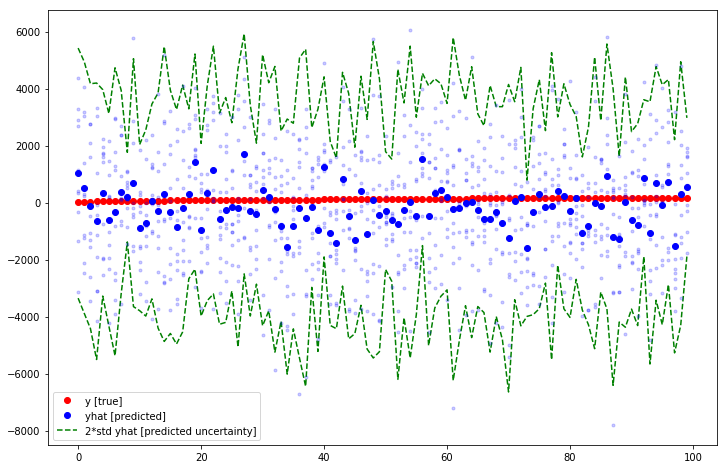

In [109]:
yhat_mu = [np.mean(x) for x in yhats]
yhat_std = [np.std(x) for x in yhats]
df = pd.DataFrame({'y':ys,'yhat_mu':yhat_mu, 'yhat_std':yhat_std})
df.sort_values(by='y', inplace=True)

plt.figure(figsize=(12,8))
plt.plot(df['y'], 'ro', label='y [true]')
plt.plot(df['yhat_mu'], 'bo', label = 'yhat [predicted]')
plt.plot(df['yhat_mu'] + 2*df['yhat_std'], 'g--', label = '2*std yhat [predicted uncertainty]')
plt.plot(df['yhat_mu'] - 2*df['yhat_std'], 'g--')
[plt.plot([y]*len(x.ravel()),x.ravel(),'b.', alpha=0.2) for x,y in zip(yhats,range(len(yhats)))]
plt.legend()
plt.show()

### visualize training 

In [12]:
plt.figure(figsize=(12,8))
plt.plot(np.log10(recorder['train']['mse']), 'r--', label='train mse')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Model training')
plt.legend()
plt.show()

NameError: name 'recorder' is not defined

<Figure size 864x576 with 0 Axes>

# Test our model

In [ ]:
net.eval()
test_total_loss = 0
yhats = []
ys = []
for X, y in test_gen:
    X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
    y = y.unsqueeze(1)
    yhat = net.forward(X)
    test_total_loss += loss_func(yhat, y).detach().numpy()
    yhats += yhat.data.numpy().ravel().tolist()
    ys += y.data.numpy().ravel().tolist()

net.train()

print(f'test mse: {test_total_loss/len(test_gen.dataset)}')

In [ ]:
df = pd.DataFrame({'y':ys, 'yhat':yhats}).assign(diff = lambda x: np.max(x.y) * (x.y-x.yhat)**2 / np.max((x.y-x.yhat)**2))

df.sort_values(by='y', inplace=True)

df = df.assign(diff_rm = df['diff'].rolling(window=10).mean())

plt.figure(figsize=(12,8))
plt.plot(df['y'].values, 'ro', label='y [true]')
plt.plot(df['yhat'].values, 'bo', label='yhat [predicted]')
plt.plot(df['diff_rm'].values, 'g--', label='scaled rolling mean quadratic error')
plt.xlabel('Sorted Observations')
plt.ylabel('Area Under the Curve (AUC)')
plt.title(f'BeatAML FCNN Test Set Predictions [n={len(test_gen.dataset)}]')
plt.legend()
plt.show()
